In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# building blocks of our network
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(0)


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
# scale the data (Tensorflow tends to prefer float data)
X_train = X_train/255.
X_test = X_test/255.

In [5]:
# out data has an image pane depth of 1
X_train_shape = np.append(X_train.shape, values=1)
X_test_shape = np.append(X_test.shape, values=1)
X_train = X_train.reshape(X_train_shape)
X_test = X_test.reshape(X_test_shape)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

In [6]:
train_ds = Dataset.from_tensor_slices((X_train, y_train))
train_dl = train_ds.batch(batch_size=4)
test_ds = Dataset.from_tensor_slices((X_test, y_test))
test_dl = test_ds.batch(batch_size=4)

In [7]:
CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
                   'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

idx, (image, label) = next(enumerate(train_ds))
idx, image.shape, label.numpy()

(0, TensorShape([28, 28, 1]), 9)

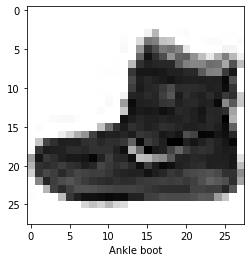

In [8]:
plt.imshow(tf.squeeze(image).numpy(), cmap = 'binary')
plt.xlabel(CLASSES[label]);

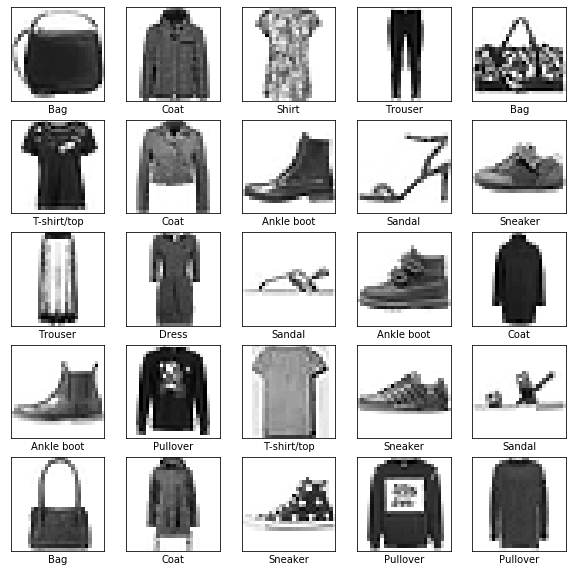

In [9]:
import numpy as np

# Tensorflow Dataset only supports sequential (not random) access
# so we need to revert to original dataset to get random items
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    idx = np.random.randint(0, len(train_ds))
    random_image, label = tf.squeeze(X_train[idx]), y_train[idx]
    plt.imshow(random_image, cmap='binary')
    plt.xlabel(CLASSES[label])

In [10]:
dropout = 0.3
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=image.shape, activation='relu')) # 28x28x32 -> 26x26x32
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu')) # 26x26x64 -> 24x24x64
model.add(MaxPool2D(2,2)) # 24x24x64 -> 12x12x64
model.add(Dropout(rate=dropout))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=dropout))
model.add(Dense(units=10, activation='softmax'))


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [12]:
def forward(X, training=False):
     return model(X, training)

# reuse native Tensorflow SCC loss - but correct order of arguments
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
def loss(y_pred, y):
    return loss_fn(y,y_pred)

def metric(y_pred, y):
    return (1. / len(y)) * tf.math.count_nonzero(tf.equal(tf.argmax(y_pred, axis=1),y),axis=0,dtype=tf.float32)

optimizer = Adam(learning_rate=0.005)

In [13]:
class ConfusionMatrix():
    def __init__(self, classes):
        self.classes = classes
        self.side = len(classes)
        self.values = np.zeros( (self.side, self.side) )
        self.total = int(0)

    def average_accuracy(self):
        return (self.values.diagonal() / self.values.sum(axis = 1).astype(float)).mean()

    def __call__(self, y_pred, y):
        for row, col in zip(y_pred, y):
          self.values[row, col] += 1      
        self.total += len(y_pred)
        return self

    def update(self, y_pred, y):
        return self.__call__(y_pred, y)

    def __repr__(self):
        msg = ""
        for i in range(self.side):
          msg += "{}: {:.2f}% ".format(self.classes[i], 100.0 * (self.values[i, i] / self.values[i,:].sum()))
        return msg


TOY_CLASSES = ['Hot dog', 'Not hot dog']
confusion_matrix = ConfusionMatrix(TOY_CLASSES)
confusion_matrix([0,1], [0,1])

Hot dog: 100.00% Not hot dog: 100.00% 

1.0

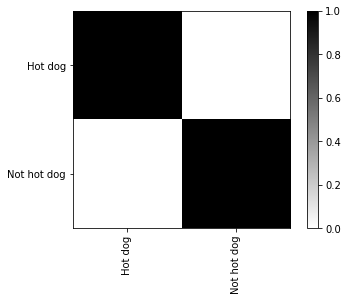

In [14]:
plt.imshow(confusion_matrix.values, cmap = 'binary')
plt.xticks(np.arange(len(TOY_CLASSES)), TOY_CLASSES, rotation = 90)
plt.yticks(np.arange(len(TOY_CLASSES)), TOY_CLASSES);
plt.colorbar();
confusion_matrix.average_accuracy()

In [15]:
training_cm = ConfusionMatrix(CLASSES)

epochs=5
for epoch in range(epochs):
    for step, (X_train_batch, y_train_batch) in enumerate(train_dl):
        with tf.GradientTape() as tape:
            # forward pass
            y_pred_batch = forward(X_train_batch, training=True)

            # compute loss
            last_loss = loss(y_pred_batch, y_train_batch)
            
        training_cm.update(tf.argmax(y_pred_batch,axis=1).numpy(), y_train_batch.numpy())
        loss_val = float(last_loss)

        if step % 1000 == 0:
            print(f'epoch {epoch+1:2d}, batch {step+1:2d}:  loss={loss_val:7.4f}, Accuracy={training_cm.average_accuracy():7.4f}')

        # back propogation
        grads = tape.gradient(last_loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # monitor performance
    print(training_cm)

/home/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


epoch  1, batch  1:  loss= 2.2618, Accuracy=    nan
epoch  1, batch 1001:  loss= 0.7331, Accuracy= 0.7035
epoch  1, batch 2001:  loss= 0.7002, Accuracy= 0.7369
epoch  1, batch 3001:  loss= 0.1185, Accuracy= 0.7523
epoch  1, batch 4001:  loss= 1.8578, Accuracy= 0.7611
epoch  1, batch 5001:  loss= 0.0080, Accuracy= 0.7689
epoch  1, batch 6001:  loss= 0.9222, Accuracy= 0.7769
epoch  1, batch 7001:  loss= 0.4490, Accuracy= 0.7824
epoch  1, batch 8001:  loss= 0.4106, Accuracy= 0.7874
epoch  1, batch 9001:  loss= 0.0652, Accuracy= 0.7905
epoch  1, batch 10001:  loss= 0.1692, Accuracy= 0.7933
epoch  1, batch 11001:  loss= 0.0357, Accuracy= 0.7958
epoch  1, batch 12001:  loss= 0.0542, Accuracy= 0.7969
epoch  1, batch 13001:  loss= 0.0496, Accuracy= 0.7992
epoch  1, batch 14001:  loss= 0.1462, Accuracy= 0.7998
T-shirt/top: 74.85% Trouser: 96.12% Pullover: 66.60% Dress: 80.55% Coat: 62.89% Sandal: 93.47% Shirt: 51.65% Sneaker: 88.99% Bag: 94.33% Ankle boot: 92.32% 
epoch  2, batch  1:  loss= 0.8

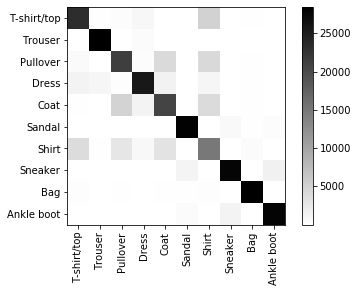

In [16]:
plt.imshow(training_cm.values, cmap = 'binary')
plt.xticks(np.arange(len(CLASSES)), CLASSES, rotation = 90)
plt.yticks(np.arange(len(CLASSES)), CLASSES);
plt.colorbar();

Copyright 2020 CounterFactual.AI LLC. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.